# Introduction to IXPEML

This notebook contains an example run through of the IXPEML pipeline on an example **simulated** and **measured** (calibration) dataset.

A 4.51keV polarized calibration file (4p51keV_pol.fits) is provided separately in a google drive (these were too large to save in the github repository). Please download them and store them in directory ```example/data``` to follow this notebook.

Check ```requirement.txt``` to install all of the python3 (this work used python 3.6.1) dependencies. Allyn has noted that the code also can work with higher version packages than those listed in ```requirement.txt```.
Note this file does not include GPDSW and GPDEXT, these are discussed below.

Let me know of any difficulties or feature requests at alpv95@stanford.edu

In [1]:
#imports
import sys
import os
os.chdir(os.path.dirname(os.getcwd()))
import numpy as np
import torch
from util.methods import *
from util.net_test import *
import pickle
import matplotlib.pyplot as plt

# this allows plots to appear directly in the notebook
%matplotlib inline

# Step 1: Raw track reconstruction

Run GPDSW reconstruction on the raw fits files, this step is the same for simulated and real (calibration) data. This requires up to date GPDSW and GPDEXT software from the [IXPE bitbucket](https://bitbucket.org/ixpesw/workspace/projects/IGS).

**We do not provide the whole of GPDSW and GPDEXT in this repository, this must be installed independently by the user.**

## Real (calibration) data

Example gpdsw commands for reconstructing real data.

```
cd gpdsw/
source setup.sh

cd bin/
./ixperecon 
        --write-tracks 
        --input-files example/data/4p51keV_pol.fits 
        --threshold 10
        --output-folder example/data
        --n 50000
```

## Simulated Data

Example gpdsw commands for simulating and reconstructing simulated data.

I recommend simulating tracks from spectral files, e.g. `flat.txt` shown below and saved in `example/data`. This is much more efficient than simulating multiple line sources.

`gpdswpy/fitsplit.py` splits the simulated fits file into two parts (one part with the monte carlo data `"_mc.fits"` and one with the rest `".fits"`) to make ixperecon run faster (otherwise it is prohibitively slow for simulated data).

Since the final `sim_spec_recon.fits` file produce by ixperecon and `"_mc.fits"` contain all the data, we can delete the original `".fits"` file to save space.

```
cd gpdsw/
source setup.sh

cd bin/
./ixpesim -n 50000 
            --random-seed 194 
            --output-file example/data/sim_spec.fits 
            --log-file example/data/sim_spec.log 
            --src-spectrum user 
            --src-spec-file example/data/flat.txt 
            --src-pol-degree 0 
            --src-pol-angle 0 
            --dme-pressure 733 

cd ..
python gpdswpy/fitsplit.py example/data/sim_spec.fits 

cd bin/ 
./ixperecon --write-tracks 
            --input-files example/data/sim_spec.fits
            --threshold 10
            --output-folder example/data/ 
            
rm example/data/sim_spec.fits

```

# Step 2: Hexagonal -> Square

Transform the fits files of hexagonal tracks into square tracks for the NNs to use. The final products of this step are directories containing:
* ```tracks_full.pickle``` (Containing sparse representations of square tracks to be read by the NNs)
* ```labels_full.pt``` (Containing all of the track metadata -- angles_simulated, angles_moments, energies, abs_pts_simulated, abs_pts_moments, ...  )

The initial hexagonal dataset is split up into 3 directories: `train/`, `test/` and `val/` (just the first two for real data). Their actual meaning is only relevant during NN training. The split fractions can be set within `run_build_fitsdata.py`.

This step is handled by ```run_build_fitsdata.py```, which contains multiple options for designing a simulated or real square dataset from hexagonal fits files.

In [2]:
!python3 run_build_fitsdata.py -h

usage: run_build_fitsdata.py [-h] [--augment {1,3}] [--npix {30,50}] [--meas]
                             [--tot TOT] [--peak_only] [--tailvpeak TAILVPEAK]
                             input_file out_base

positional arguments:
  input_file            input folder or file
  out_base              output folder

optional arguments:
  -h, --help            show this help message and exit
  --augment {1,3}       Number of Track augmentation randomly distributed in
                        dataset. These should always be 3 during inference and
                        1 during training
  --npix {30,50}        Number of pixels in square conversions. This should be
                        50 for >= v1.2
  --meas                Whether data is real or simulated, if squaring
                        measured data this argument is required
  --tot TOT             The total number of tracks to convert to square
  --peak_only           No low or high Z tail tracks
  --tailvpeak TAILVPEAK
           

## Make simulated square dataset

In [13]:
#Simulated Tracks
!python3 run_build_fitsdata.py example/data/sim_spec_recon.fits example/data --tot 50000  


Directory already exists for Simulated
Building  50000 tracks of example/data/sim_spec_recon.fits
50000 loaded ok
50000 post cut
Final size:  torch.Size([50000, 3])
Finished 

Saved,  example/data/train/


## Make measured square dataset

In [24]:
#Measured (calibration) data 
#use --meas flag:

!python3 run_build_fitsdata.py example/data/4p51keV_pol_recon.fits example/data/meas4p51 --meas

Total number of unique tracks = 50000

Directory already exists
No Monte Carlo, measured data only 

50000 loaded ok
Final size:  torch.Size([50000])
Finished 

Saved,  example/data/meas4p51


# Step 3: Deep Ensemble

Run square track datasets through the deep ensemble of NNs. **This requires a GPU available (the more the merrier).**
This step is run with ```run_ensemble_eval.py```; the results are saved in a fits file specified with ```save_name```.

The only difference between simulated and measured data is the ```---datatype``` flag.

**Notes:**
* I suggest playing with the `batch_size` parameter in `net_test.py` if the code is throwing GPU memory based errors. It should always be a factor of 2, e.g. 512, 1024, 2048, 4096. Higher batch size means faster runtime but more memory usage on the GPUs.

In [27]:
!python3 run_ensemble_eval.py -h

usage: run_ensemble_eval.py [-h]
                            [--ensemble {bessel_rand,bessel_rand_small,heads_only,tailvpeak,energy,flat_weight}]
                            [--data_list DATA_LIST [DATA_LIST ...]]
                            [--datatype {sim,meas}]
                            [--stokes_correct {2.0,2.3,2.7,3.1,3.7,5.9}]
                            save_name

positional arguments:
  save_name             Save Net FoV results in Pandas dataframe with this
                        name

optional arguments:
  -h, --help            show this help message and exit
  --ensemble {bessel_rand,bessel_rand_small,heads_only,tailvpeak,energy,flat_weight}
                        Which network ensemble to use: Ensemble prediction or
                        single prediction
  --data_list DATA_LIST [DATA_LIST ...]
                        List of Data to evaluate on
  --datatype {sim,meas}
                        Simulated or Measured track data
  --stokes_correct {2.0,2.3,2.7,3.1,3.7,5

### Simulated Data

In [6]:
#Run tracks through deep ensemble (requires GPU available)
print("Number of GPUs available: {}\n".format(torch.cuda.device_count()))

!python3 run_ensemble_eval.py nn_sim_spec --data_list example/data/train/

Number of GPUs available: 2

Evaluating using ensemble: 
 ['733bessel3/models/mom_1024_91.ptmodel', '733bessel3/models/mom_512_171.ptmodel', '733bessel1/models/mom_1024_91.ptmodel', '733bessel2/models/RLRP_512_91.ptmodel', '733bessel2/models/mom_4096_171.ptmodel', '733bessel1/models/RLRP_1024_131.ptmodel', '733bessel2/models/RLRP_2048_91.ptmodel', '733bessel1/models/RLRP_4096_131.ptmodel', '733bessel3/models/mom_4096_151.ptmodel']

 9 NNs in the ensemble 

>> NN 1/9 : 

Loading full dataset into memory

Dataset size:  50000
Let's use 2 GPUs!
Evaluating on GPU 

>> Complete
>> NN 2/9 : 

Loading full dataset into memory

Dataset size:  50000
Let's use 2 GPUs!
Evaluating on GPU 

>> Complete
>> NN 3/9 : 

Loading full dataset into memory

Dataset size:  50000
Let's use 2 GPUs!
Evaluating on GPU 

>> Complete
>> NN 4/9 : 

Loading full dataset into memory

Dataset size:  50000
Let's use 2 GPUs!
Evaluating on GPU 

>> Complete
>> NN 5/9 : 

Loading full dataset into memory

Dataset size:  

### Measured Data

In [8]:
#Run tracks through deep ensemble (requires GPU available)
print("Number of GPUs available: {}\n".format(torch.cuda.device_count()))

!python3 run_ensemble_eval.py nn_4p51 --data_list example/data/meas4p51/ --datatype meas

Number of GPUs available: 2

Evaluating using ensemble: 
 ['733bessel3/models/mom_1024_91.ptmodel', '733bessel3/models/mom_512_171.ptmodel', '733bessel1/models/mom_1024_91.ptmodel', '733bessel2/models/RLRP_512_91.ptmodel', '733bessel2/models/mom_4096_171.ptmodel', '733bessel1/models/RLRP_1024_131.ptmodel', '733bessel2/models/RLRP_2048_91.ptmodel', '733bessel1/models/RLRP_4096_131.ptmodel', '733bessel3/models/mom_4096_151.ptmodel']

 9 NNs in the ensemble 

>> NN 1/9 : 

Loading full dataset into memory

Dataset size:  50000
Let's use 2 GPUs!
Evaluating on GPU 

>> Complete
>> NN 2/9 : 

Loading full dataset into memory

Dataset size:  50000
Let's use 2 GPUs!
Evaluating on GPU 

>> Complete
>> NN 3/9 : 

Loading full dataset into memory

Dataset size:  50000
Let's use 2 GPUs!
Evaluating on GPU 

>> Complete
>> NN 4/9 : 

Loading full dataset into memory

Dataset size:  50000
Let's use 2 GPUs!
Evaluating on GPU 

>> Complete
>> NN 5/9 : 

Loading full dataset into memory

Dataset size:  

# Step 4: Analyze results / Postprocess

Full results from the deep ensembles and moment analysis are saved in a single fits file, just like the moment analysis `_recon.fits`.

## Loading results for analysis

In [10]:
#Simulated
with fits.open('_example_data_train___nn_sim_spec__ensemble.fits', memmap=False) as hdu:
    sim_results = hdu[1].data

#Measured
with fits.open('_example_data_meas4p51___nn_4p51__ensemble.fits', memmap=False) as hdu:
    meas_results = hdu[1].data

In [11]:
sim_results.columns

ColDefs(
    name = 'NN_PHI'; format = 'E'
    name = 'MOM_PHI'; format = 'E'
    name = 'PHI'; format = 'E'
    name = 'MOM_ELLIP'; format = 'E'
    name = 'NN_WEIGHT'; format = 'E'
    name = 'NN_ABS'; format = '2E'; dim = '(2)'
    name = 'MOM_ABS'; format = '2E'; dim = '(2)'
    name = 'XY_MOM_ABS'; format = '2E'; dim = '(2)'
    name = 'ABS'; format = '2E'; dim = '(3)'
    name = 'ENERGY'; format = 'E'
    name = 'NN_ENERGY'; format = 'E'
    name = 'XY_NN_ABS'; format = '2E'; dim = '(2)'
    name = 'XYZ_ABS'; format = '3E'; dim = '(3)'
    name = 'MOM_ENERGY'; format = 'E'
    name = 'NN_WEIGHT_EPIS'; format = 'E'
)

In [12]:
meas_results.columns

ColDefs(
    name = 'NN_PHI'; format = 'E'
    name = 'MOM_PHI'; format = 'E'
    name = 'MOM_ELLIP'; format = 'E'
    name = 'NN_WEIGHT'; format = 'E'
    name = 'NN_ABS'; format = '2E'; dim = '(2)'
    name = 'MOM_ABS'; format = '2E'; dim = '(2)'
    name = 'XY_MOM_ABS'; format = '2E'; dim = '(2)'
    name = 'NN_ENERGY'; format = 'E'
    name = 'XY_NN_ABS'; format = '2E'; dim = '(2)'
    name = 'MOM_ENERGY'; format = 'E'
    name = 'TRG_ID'; format = 'J'
    name = 'FLAG'; format = 'J'
    name = 'NN_WEIGHT_EPIS'; format = 'E'
)

## Analyse polarization results with weighted Stokes' analysis

`util/methods.py' contains the majority of our polarization analysis functions, including weighted Stokes parameters.

(mu, theta0, Neff, mu_err, theta0_err)
(0.43072620656377464, -0.6558844898547604, 50000.0, 0.006024136826473457, 0.007341808404571988)
(0.3817742289055782, -0.6315598712586169, 50000.0, 0.006089803812692209, 0.008283192117196166)

 Weighted
(mu, theta0, Neff, mu_err, theta0_err)
(0.5338425902264442, -0.6405847668647766, 39792.94111524956, 0.00656501964814763, 0.006640093893139687)
(0.4561559269803965, -0.6256769299507141, 37513.306244697334, 0.006911505218507016, 0.008003589344836224)


/share/software/user/open/py-matplotlib/2.1.2_py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


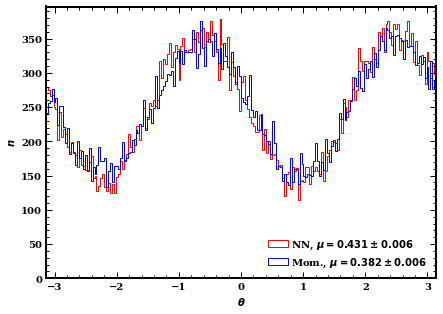

In [33]:
fig, ax = plt.subplots(figsize=(7,5))
print("(mu, theta0, Neff, mu_err, theta0_err)")
mu, _, _, mu_err, _ = weighted_stokes(meas_results['NN_PHI'], error=True)
mu_mom, _, _, mu_err_mom, _ = weighted_stokes(meas_results['MOM_PHI'], error=True)
print(weighted_stokes(meas_results['NN_PHI'], error=True))
print(weighted_stokes(meas_results['MOM_PHI'], error=True))

print("\n Weighted")
print("(mu, theta0, Neff, mu_err, theta0_err)")
print(weighted_stokes(meas_results['NN_PHI'], meas_results['NN_WEIGHT'], error=True))
print(weighted_stokes(meas_results['MOM_PHI'], meas_results['MOM_ELLIP'], error=True))

h = ax.hist(meas_results['NN_PHI'], histtype='step', bins=200,color='r',label=f'NN, $\mu = {mu:.3} \pm {mu_err:.1}$')
h = ax.hist(meas_results['MOM_PHI'], histtype='step', bins=200,color='b',label=f'Mom., $\mu = {mu_mom:.3} \pm {mu_err_mom:.1}$')

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$n$")
ax.set_xlim(-np.pi,np.pi)

leg = ax.legend(loc = 4,)